Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import scipy.io
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs

# Sample from latent Lorenz attractor:


In [2]:
Time = 300
neuron_num = 30
datax = scipy.io.loadmat("spike30_sim_1500.mat")
y_data = datax["spike30_sim_1500"] 
traj = scipy.io.loadmat("trj30_sim_1500.mat")
traj = traj["trj30_sim_1500"]

(300, 30)


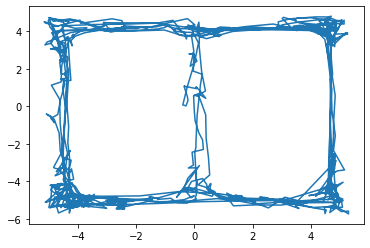

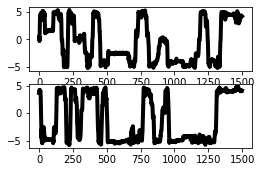

In [3]:
factor_dim = 2

NRep=5
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    output[i,:,:] = y_data[300*i:300*(i+1),:]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)

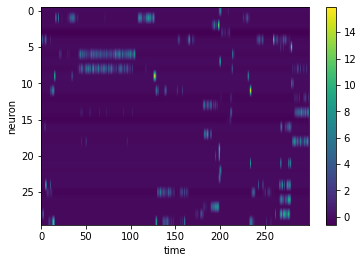

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('time')
plt.ylabel('neuron')
plt.colorbar()
plt.show()

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((output))
#print(dataset)
#dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        #self.dense_output = tf.keras.layers.Dense(64, activation='relu')
        self.dense_output2 = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        #xo = self.dense_output(x)
        xo = self.dense_output2(x)
        #xo = 5*tf.exp(tf.nn.tanh(self.dense_output2(xo)))
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [11]:
BATCH_SIZE = 1
batched_dataset = dataset.batch(BATCH_SIZE)

In [12]:
vae = VariationalAutoEncoder(latent_dim=32,
                             num_gru_unit=32,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=2)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,10)

In [ ]:
epochs = 3000

for i,kl_ in enumerate(KL_penalty):
    print(kl_,i)
    if i > 0:
        break
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,),'i',i)

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            print("step",step)
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                #print("loss",loss,"kl",sum(vae.losses))
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

0.0 0
Start of epoch 0 i 0
step 0
step 0: mean loss = 1.1666652
step 1
step 2
step 3
step 4
Start of epoch 1 i 0
step 0
step 0: mean loss = 1.0281699
step 1
step 2
step 3
step 4
Start of epoch 2 i 0
step 0
step 0: mean loss = 1.0154552
step 1
step 2
step 3
step 4
Start of epoch 3 i 0
step 0
step 0: mean loss = 1.0105764
step 1
step 2
step 3
step 4
Start of epoch 4 i 0
step 0
step 0: mean loss = 1.008006
step 1
step 2
step 3
step 4
Start of epoch 5 i 0
step 0
step 0: mean loss = 1.0063821
step 1
step 2
step 3
step 4
Start of epoch 6 i 0
step 0
step 0: mean loss = 1.0052778
step 1
step 2
step 3
step 4
Start of epoch 7 i 0
step 0
step 0: mean loss = 1.0044678
step 1
step 2
step 3
step 4
Start of epoch 8 i 0
step 0
step 0: mean loss = 1.0038209
step 1
step 2
step 3
step 4
Start of epoch 9 i 0
step 0
step 0: mean loss = 1.003301
step 1
step 2
step 3
step 4
Start of epoch 10 i 0
step 0
step 0: mean loss = 1.0028256
step 1
step 2
step 3
step 4
Start of epoch 11 i 0
step 0
step 0: mean loss = 

Start of epoch 94 i 0
step 0
step 0: mean loss = 0.93744326
step 1
step 2
step 3
step 4
Start of epoch 95 i 0
step 0
step 0: mean loss = 0.93710846
step 1
step 2
step 3
step 4
Start of epoch 96 i 0
step 0
step 0: mean loss = 0.93678844
step 1
step 2
step 3
step 4
Start of epoch 97 i 0
step 0
step 0: mean loss = 0.93645144
step 1
step 2
step 3
step 4
Start of epoch 98 i 0
step 0
step 0: mean loss = 0.9361161
step 1
step 2
step 3
step 4
Start of epoch 99 i 0
step 0
step 0: mean loss = 0.93583834
step 1
step 2
step 3
step 4
Start of epoch 100 i 0
step 0
step 0: mean loss = 0.93551964
step 1
step 2
step 3
step 4
Start of epoch 101 i 0
step 0
step 0: mean loss = 0.93519753
step 1
step 2
step 3
step 4
Start of epoch 102 i 0
step 0
step 0: mean loss = 0.93487686
step 1
step 2
step 3
step 4
Start of epoch 103 i 0
step 0
step 0: mean loss = 0.9345638
step 1
step 2
step 3
step 4
Start of epoch 104 i 0
step 0
step 0: mean loss = 0.9342539
step 1
step 2
step 3
step 4
Start of epoch 105 i 0
step 0


step 3
step 4
Start of epoch 187 i 0
step 0
step 0: mean loss = 0.92000645
step 1
step 2
step 3
step 4
Start of epoch 188 i 0
step 0
step 0: mean loss = 0.91989404
step 1
step 2
step 3
step 4
Start of epoch 189 i 0
step 0
step 0: mean loss = 0.9197808
step 1
step 2
step 3
step 4
Start of epoch 190 i 0
step 0
step 0: mean loss = 0.9196686
step 1
step 2
step 3
step 4
Start of epoch 191 i 0
step 0
step 0: mean loss = 0.9195573
step 1
step 2
step 3
step 4
Start of epoch 192 i 0
step 0
step 0: mean loss = 0.9194517
step 1
step 2
step 3
step 4
Start of epoch 193 i 0
step 0
step 0: mean loss = 0.9193569
step 1
step 2
step 3
step 4
Start of epoch 194 i 0
step 0
step 0: mean loss = 0.91926724
step 1
step 2
step 3
step 4
Start of epoch 195 i 0
step 0
step 0: mean loss = 0.9191675
step 1
step 2
step 3
step 4
Start of epoch 196 i 0
step 0
step 0: mean loss = 0.91906124
step 1
step 2
step 3
step 4
Start of epoch 197 i 0
step 0
step 0: mean loss = 0.91895473
step 1
step 2
step 3
step 4
Start of epoc

step 2
step 3
step 4
Start of epoch 280 i 0
step 0
step 0: mean loss = 0.9131974
step 1
step 2
step 3
step 4
Start of epoch 281 i 0
step 0
step 0: mean loss = 0.913136
step 1
step 2
step 3
step 4
Start of epoch 282 i 0
step 0
step 0: mean loss = 0.91307795
step 1
step 2
step 3
step 4
Start of epoch 283 i 0
step 0
step 0: mean loss = 0.91302764
step 1
step 2
step 3
step 4
Start of epoch 284 i 0
step 0
step 0: mean loss = 0.9129785
step 1
step 2
step 3
step 4
Start of epoch 285 i 0
step 0
step 0: mean loss = 0.9129269
step 1
step 2
step 3
step 4
Start of epoch 286 i 0
step 0
step 0: mean loss = 0.9128719
step 1
step 2
step 3
step 4
Start of epoch 287 i 0
step 0
step 0: mean loss = 0.91281533
step 1
step 2
step 3
step 4
Start of epoch 288 i 0
step 0
step 0: mean loss = 0.91275626
step 1
step 2
step 3
step 4
Start of epoch 289 i 0
step 0
step 0: mean loss = 0.9126974
step 1
step 2
step 3
step 4
Start of epoch 290 i 0
step 0
step 0: mean loss = 0.9126382
step 1
step 2
step 3
step 4
Start of

step 2
step 3
step 4
Start of epoch 373 i 0
step 0
step 0: mean loss = 0.9090967
step 1
step 2
step 3
step 4
Start of epoch 374 i 0
step 0
step 0: mean loss = 0.9090661
step 1
step 2
step 3
step 4
Start of epoch 375 i 0
step 0
step 0: mean loss = 0.9090423
step 1
step 2
step 3
step 4
Start of epoch 376 i 0
step 0
step 0: mean loss = 0.9090065
step 1
step 2
step 3
step 4
Start of epoch 377 i 0
step 0
step 0: mean loss = 0.9089701
step 1
step 2
step 3
step 4
Start of epoch 378 i 0
step 0
step 0: mean loss = 0.908934
step 1
step 2
step 3
step 4
Start of epoch 379 i 0
step 0
step 0: mean loss = 0.90890014
step 1
step 2
step 3
step 4
Start of epoch 380 i 0
step 0
step 0: mean loss = 0.90886533
step 1
step 2
step 3
step 4
Start of epoch 381 i 0
step 0
step 0: mean loss = 0.9088335
step 1
step 2
step 3
step 4
Start of epoch 382 i 0
step 0
step 0: mean loss = 0.90880084
step 1
step 2
step 3
step 4
Start of epoch 383 i 0
step 0
step 0: mean loss = 0.9087709
step 1
step 2
step 3
step 4
Start of 

step 2
step 3
step 4
Start of epoch 466 i 0
step 0
step 0: mean loss = 0.9062688
step 1
step 2
step 3
step 4
Start of epoch 467 i 0
step 0
step 0: mean loss = 0.9062479
step 1
step 2
step 3
step 4
Start of epoch 468 i 0
step 0
step 0: mean loss = 0.90622896
step 1
step 2
step 3
step 4
Start of epoch 469 i 0
step 0
step 0: mean loss = 0.90620786
step 1
step 2
step 3
step 4
Start of epoch 470 i 0
step 0
step 0: mean loss = 0.90618646
step 1
step 2
step 3
step 4
Start of epoch 471 i 0
step 0
step 0: mean loss = 0.9061582
step 1
step 2
step 3
step 4
Start of epoch 472 i 0
step 0
step 0: mean loss = 0.9061305
step 1
step 2
step 3
step 4
Start of epoch 473 i 0
step 0
step 0: mean loss = 0.90610296
step 1
step 2
step 3
step 4
Start of epoch 474 i 0
step 0
step 0: mean loss = 0.9060765
step 1
step 2
step 3
step 4
Start of epoch 475 i 0
step 0
step 0: mean loss = 0.90605295
step 1
step 2
step 3
step 4
Start of epoch 476 i 0
step 0
step 0: mean loss = 0.90602916
step 1
step 2
step 3
step 4
Start

step 2
step 3
step 4
Start of epoch 559 i 0
step 0
step 0: mean loss = 0.90416557
step 1
step 2
step 3
step 4
Start of epoch 560 i 0
step 0
step 0: mean loss = 0.9041451
step 1
step 2
step 3
step 4
Start of epoch 561 i 0
step 0
step 0: mean loss = 0.9041254
step 1
step 2
step 3
step 4
Start of epoch 562 i 0
step 0
step 0: mean loss = 0.90410703
step 1
step 2
step 3
step 4
Start of epoch 563 i 0
step 0
step 0: mean loss = 0.9040886
step 1
step 2
step 3
step 4
Start of epoch 564 i 0
step 0
step 0: mean loss = 0.9040713
step 1
step 2
step 3
step 4
Start of epoch 565 i 0
step 0
step 0: mean loss = 0.90405345
step 1
step 2
step 3
step 4
Start of epoch 566 i 0
step 0
step 0: mean loss = 0.904036
step 1
step 2
step 3
step 4
Start of epoch 567 i 0
step 0
step 0: mean loss = 0.9040172
step 1
step 2
step 3
step 4
Start of epoch 568 i 0
step 0
step 0: mean loss = 0.90399766
step 1
step 2
step 3
step 4
Start of epoch 569 i 0
step 0
step 0: mean loss = 0.9039775
step 1
step 2
step 3
step 4
Start of

step 2
step 3
step 4
Start of epoch 652 i 0
step 0
step 0: mean loss = 0.90259874
step 1
step 2
step 3
step 4
Start of epoch 653 i 0
step 0
step 0: mean loss = 0.90258145
step 1
step 2
step 3
step 4
Start of epoch 654 i 0
step 0
step 0: mean loss = 0.9025638
step 1
step 2
step 3
step 4
Start of epoch 655 i 0
step 0
step 0: mean loss = 0.9025464
step 1
step 2
step 3
step 4
Start of epoch 656 i 0
step 0
step 0: mean loss = 0.90252894
step 1
step 2
step 3
step 4
Start of epoch 657 i 0
step 0
step 0: mean loss = 0.90251195
step 1
step 2
step 3
step 4
Start of epoch 658 i 0
step 0
step 0: mean loss = 0.90249634
step 1
step 2
step 3
step 4
Start of epoch 659 i 0
step 0
step 0: mean loss = 0.9024836
step 1
step 2
step 3
step 4
Start of epoch 660 i 0
step 0
step 0: mean loss = 0.902471
step 1
step 2
step 3
step 4
Start of epoch 661 i 0
step 0
step 0: mean loss = 0.9024594
step 1
step 2
step 3
step 4
Start of epoch 662 i 0
step 0
step 0: mean loss = 0.90244514
step 1
step 2
step 3
step 4
Start 

step 2
step 3
step 4
Start of epoch 745 i 0
step 0
step 0: mean loss = 0.90128744
step 1
step 2
step 3
step 4
Start of epoch 746 i 0
step 0
step 0: mean loss = 0.9012746
step 1
step 2
step 3
step 4
Start of epoch 747 i 0
step 0
step 0: mean loss = 0.9012619
step 1
step 2
step 3
step 4
Start of epoch 748 i 0
step 0
step 0: mean loss = 0.9012491
step 1
step 2
step 3
step 4
Start of epoch 749 i 0
step 0
step 0: mean loss = 0.90123624
step 1
step 2
step 3
step 4
Start of epoch 750 i 0
step 0
step 0: mean loss = 0.90122235
step 1
step 2
step 3
step 4
Start of epoch 751 i 0
step 0
step 0: mean loss = 0.9012077
step 1
step 2
step 3
step 4
Start of epoch 752 i 0
step 0
step 0: mean loss = 0.90119356
step 1
step 2
step 3
step 4
Start of epoch 753 i 0
step 0
step 0: mean loss = 0.90117985
step 1
step 2
step 3
step 4
Start of epoch 754 i 0
step 0
step 0: mean loss = 0.9011657
step 1
step 2
step 3
step 4
Start of epoch 755 i 0
step 0
step 0: mean loss = 0.9011524
step 1
step 2
step 3
step 4
Start 

step 2
step 3
step 4
Start of epoch 838 i 0
step 0
step 0: mean loss = 0.9002657
step 1
step 2
step 3
step 4
Start of epoch 839 i 0
step 0
step 0: mean loss = 0.9002533
step 1
step 2
step 3
step 4
Start of epoch 840 i 0
step 0
step 0: mean loss = 0.9002403
step 1
step 2
step 3
step 4
Start of epoch 841 i 0
step 0
step 0: mean loss = 0.9002273
step 1
step 2
step 3
step 4
Start of epoch 842 i 0
step 0
step 0: mean loss = 0.90021473
step 1
step 2
step 3
step 4
Start of epoch 843 i 0
step 0
step 0: mean loss = 0.9002022
step 1
step 2
step 3
step 4
Start of epoch 844 i 0
step 0
step 0: mean loss = 0.9001896
step 1
step 2
step 3
step 4
Start of epoch 845 i 0
step 0
step 0: mean loss = 0.9001769
step 1
step 2
step 3
step 4
Start of epoch 846 i 0
step 0
step 0: mean loss = 0.900165
step 1
step 2
step 3
step 4
Start of epoch 847 i 0
step 0
step 0: mean loss = 0.90015304
step 1
step 2
step 3
step 4
Start of epoch 848 i 0
step 0
step 0: mean loss = 0.90014154
step 1
step 2
step 3
step 4
Start of 

step 2
step 3
step 4
Start of epoch 931 i 0
step 0
step 0: mean loss = 0.8992098
step 1
step 2
step 3
step 4
Start of epoch 932 i 0
step 0
step 0: mean loss = 0.899199
step 1
step 2
step 3
step 4
Start of epoch 933 i 0
step 0
step 0: mean loss = 0.89918876
step 1
step 2
step 3
step 4
Start of epoch 934 i 0
step 0
step 0: mean loss = 0.89917856
step 1
step 2
step 3
step 4
Start of epoch 935 i 0
step 0
step 0: mean loss = 0.8991699
step 1
step 2
step 3
step 4
Start of epoch 936 i 0
step 0
step 0: mean loss = 0.89916164
step 1
step 2
step 3
step 4
Start of epoch 937 i 0
step 0
step 0: mean loss = 0.8991517
step 1
step 2
step 3
step 4
Start of epoch 938 i 0
step 0
step 0: mean loss = 0.89914054
step 1
step 2
step 3
step 4
Start of epoch 939 i 0
step 0
step 0: mean loss = 0.899129
step 1
step 2
step 3
step 4
Start of epoch 940 i 0
step 0
step 0: mean loss = 0.899117
step 1
step 2
step 3
step 4
Start of epoch 941 i 0
step 0
step 0: mean loss = 0.8991053
step 1
step 2
step 3
step 4
Start of e

In [ ]:
print(vae(x_batch_train).shape)
for i in range(neuron_num):
    plt.figure()
    plt.plot(vae(x_batch_train)[0,:,i],"r")
    plt.plot(output[0,:,i],'k')
    plt.plot(x_batch_train[0,:,i],'b')

# Evaluate Quality of reconstruction 

In [ ]:
for x in batched_dataset.take(1):
    print(x.shape)
    qz_mean_est = vae.latent(x)
    print(qz_mean_est.shape)

qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
print(qz_est_norm[0].shape)

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
print(z_true_norm.shape)
#R = funs.compute_optimal_rotation(np.stack(qz_est_norm[0]), z_true_norm, scale=True)
qz_est_norm_R = qz_est_norm#np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[0,:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[0,:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[0,:,0], qz_est_norm_R[0,:,1], lw=2, color = 'r')